In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics

In [23]:
train_df, test_df = pd.read_csv('train.csv'), pd.read_csv('test.csv')

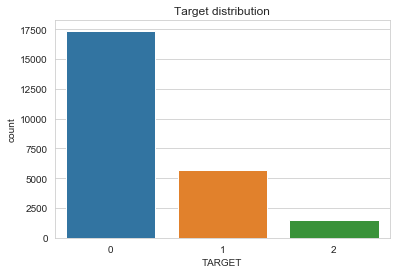

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='TARGET', data=train_df).set_title('Target distribution');

In [25]:
train_df = train_df.fillna(-9999)
test_df = test_df.fillna(-9999)

In [26]:
train_y = train_df.pop('TARGET')
train_df.drop('ID', axis=1, inplace=True)
submission_df = pd.DataFrame(test_df.pop('ID'), columns=['ID'])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_y, test_size=0.2, random_state=35, stratify=train_y)

In [28]:
from sklearn.metrics import f1_score

def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 


model = lgb.LGBMClassifier(
    random_state = 35,
    learning_rate=0.05,
    n_estimators=1000,
    objective='multiclass',
    class_weight='balanced',
    n_jobs=-1)
model.fit(X_train, y_train,
          eval_metric= evaluate_macroF1_lgb,
          eval_set= (X_test,
                      y_test),
          early_stopping_rounds=300,
          verbose=100)
print(); print(model)

Training until validation scores don't improve for 300 rounds
[100]	valid_0's multi_logloss: 0.817881	valid_0's macroF1: 0.510912
[200]	valid_0's multi_logloss: 0.762778	valid_0's macroF1: 0.528985
[300]	valid_0's multi_logloss: 0.733545	valid_0's macroF1: 0.539121
[400]	valid_0's multi_logloss: 0.71598	valid_0's macroF1: 0.538375
[500]	valid_0's multi_logloss: 0.70332	valid_0's macroF1: 0.542236
[600]	valid_0's multi_logloss: 0.694682	valid_0's macroF1: 0.541329
[700]	valid_0's multi_logloss: 0.688686	valid_0's macroF1: 0.535792
Early stopping, best iteration is:
[492]	valid_0's multi_logloss: 0.70428	valid_0's macroF1: 0.54458

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective='multiclass',
               random_st

In [29]:
expected_y  = train_y
predicted_y = model.predict(train_df)
print(); print('LightGBM classification report: ')
print(); print(metrics.classification_report(expected_y, predicted_y))
print(); print(metrics.confusion_matrix(expected_y, predicted_y)) #55


LightGBM classification report: 

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     17372
           1       0.78      0.85      0.81      5650
           2       0.78      0.91      0.84      1499

    accuracy                           0.89     24521
   macro avg       0.84      0.89      0.86     24521
weighted avg       0.90      0.89      0.90     24521


[[15783  1304   285]
 [  771  4780    99]
 [   67    67  1365]]


In [30]:
print(); print('Predicted classes distribution: ')
pred_y = model.predict(test_df)
submission_df['TARGET'] = pred_y
sub_file = 'contest_answer.csv'
submission_df.to_csv(sub_file, index=False)

submission_df['TARGET'].value_counts()


Predicted classes distribution: 


0    5770
1    2748
2     966
Name: TARGET, dtype: int64

In [31]:
pred_proba_y = model.predict_proba(test_df)
submission_df = pd.concat([submission_df, pd.DataFrame(pred_proba_y, columns=["Proba_0", "Proba_1","Proba_2"])], axis=1)

In [32]:
seg_1 = submission_df[submission_df['TARGET'] == 0].copy()
seg_2 = submission_df[submission_df['TARGET'] == 1].copy()
seg_3 = submission_df[submission_df['TARGET'] == 2].copy()

seg_1_cut = seg_1.sort_values(by=['Proba_0'], ascending=False)[:1000]
seg_2_cut = seg_2.sort_values(by=['Proba_1'], ascending=False)[:500]
seg_3_cut = seg_3.sort_values(by=['Proba_2'], ascending=False)[:200]

submission_df2 = pd.concat([seg_1_cut, seg_2_cut, seg_3_cut])

In [33]:
submission_df2.drop(['Proba_0', 'Proba_1', 'Proba_2'], axis=1, inplace=True)
sub_file2 = 'contest_segments.csv'
submission_df2.to_csv(sub_file2, index=False)